# LUCAS sampling fallow active agricultural areas
The goal of the script is to create a workflow to extract candidate forest and nonforest endmemebrs across the EU, in a spatially and temporally representative manner. The output of this script is a extensive data frame of labelled points and their respective spectral bands/STMs. This data frame can then be used to identify endmebers used for subsequent synthetic mixing, training and predicting

### Load libraries and set file paths
* local function collection
* shapefile $\rightarrow$ first for a test shapefile, later for the project files

In [1]:
from osgeo import ogr, osr, gdal
import geemap, ee
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from scipy.stats import norm, gamma, f, chi2
from functools import partial
import concurrent.futures
import pickle
import logging
import os
import sys
import warnings



Import functions from Custom python tools helper scripts

In [2]:
#workPath = 'D:/OneDrive - Humboldt-Universitaet zu Berlin, CMS/uni/WS_23_24/Geopy/MAP_git'
#workPath = "/Users/rubenbutzer/Library/CloudStorage/OneDrive-Humboldt-UniversitaetzuBerlin,CMS/uni/WS_23_24/Geopy/MAP_git"
workPath = 'E:/MAP_git'

In [3]:
sys.path.append(workPath)
from tools import *
from tools_schnesha import *
from tools_butzerru import *

In [4]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

### Open a map object that we populate

In [6]:
# Instantiate the map
Map01 = geemap.Map(zoom=10) # instantiates a map object with a zoom lelve
# Add a baselayer
Map01.add_basemap('SATELLITE')
# Call the map object
Map01

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Run the analysis

#### 1. Load the project site shapefile and load the geometry into the map window

In [7]:
# smaller DE shape used for testing
#envelope, projSite = ProjSite_ToeeGeom(workPath + "/00_Shapefiles/wildE/DEU.gpkg")

# larget aggregated shp of the entire eu (wildE study area)
envelope, projSite = ProjSite_ToeeGeom(workPath + "/00_Shapefiles/wildE/europe_aggregated.gpkg")

# add extents of analyis
Map01.addLayer(envelope, {'color': '000000', 'width': 1, 'lineType': 'solid', 'fillColor': '00000000'}, 'Analysis Boundary')
Map01.addLayer(projSite, {'color': 'fa0000', 'width': 1, 'lineType': 'solid', 'fillColor': '00000000'}, 'Project site')
Map01.centerObject(projSite)

run this chunk in case you want to delete a layer on the map

In [ ]:
#Map01.remove_ee_layer('enterlayername')

## Same Approach from local and standard wildE Europe grid

#### ogr code to generate reproject wildE grid 

ogr2ogr -f GPKG -s_srs EPSG:3035 -t_srs EPSG:4326 /Volumes/_wildE_Mapping/00_Shapefiles/grid_europe_4326.gpkg /Volumes/_wildE_Mapping/00_Shapefiles/grid_europe.gpkg

### Method to create ee.features from the locally stored wildE grid gpkg

In [9]:
tileSHP = CopySHPtoMem(workPath + "/00_Shapefiles/grid_europe_4326.gpkg")
tileLYR = tileSHP.GetLayer()
tileFEAT = tileLYR.GetNextFeature()
featList = []
while tileFEAT:
# Get the feature geometry and its ID
    geom = tileFEAT.GetGeometryRef()
    featID = tileFEAT.GetField("id")
    active_YN = tileFEAT.GetField("Active_YN")
    if active_YN == 1:
    # Build the EE-feature via the json-conversion
        geom_json = json.loads(geom.ExportToJson())
        geom_coord = geom_json['coordinates']
        geom_EE = ee.Geometry.Polygon(coords=geom_coord)
        feat_EE = ee.Feature(geom_EE, {"Id": featID})
    # Add to the list, take next feature
        featList.append(feat_EE)
    tileFEAT = tileLYR.GetNextFeature()
    
tileLYR.ResetReading()
# Convert the featList into an EE FeatureCollection
tiles = ee.FeatureCollection(ee.List(featList))
features = ee.Feature(tiles.first()).propertyNames().sort()  # Something Julian did in his script
tile_names = tiles.distinct("Id").aggregate_array("Id").getInfo()

In [14]:
# Importiere das Earth Engine Python API
import ee

# Setze das Earth Engine-Konto
ee.Initialize()

# Instanziiere die Karte
Map01 = geemap.Map(zoom=10) # instanziiert ein Kartenobjekt mit einem Zoomlevel
# Füge eine Grundkarte hinzu
Map01.add_basemap('SATELLITE')

# Definiere die Farben für die Features basierend auf Active_YN
palette = ['orange', 'red']  # Rot für inaktive und Grün für aktive

# Füge die Feature-Sammlung als Layer zur Karte hinzu
Map01.addLayer(tiles, {'color': palette[0], 'fillColor': palette[1]}, 'Tiles')

# Zentriere die Karte auf die Feature-Sammlung
Map01.centerObject(tiles)

# Zeige die Karte an
Map01


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Method to create ogr.features from the local wildE grid


In [8]:
# Open the input shapefile
tileSHP = CopySHPtoMem(workPath + "/00_Shapefiles/grid_europe_4326.gpkg")
if tileSHP is None:
    print("Failed to open input shapefile.")
    exit(1)

# Get the input layer
tileLYR = tileSHP.GetLayer()

# Create a memory (in-memory) data source
mem_driver = ogr.GetDriverByName("Memory")
mem_ds = mem_driver.CreateDataSource("")

# Create an output layer in memory with the same schema as the input layer
grid_wildE = mem_ds.CreateLayer(tileLYR.GetName(), geom_type=tileLYR.GetGeomType())

# Copy the fields from the input layer to the output layer
grid_wildE.CreateFields(tileLYR.schema)

tileFEAT = tileLYR.GetNextFeature()

while tileFEAT:
    # Get the feature geometry and its ID
    geom = tileFEAT.GetGeometryRef()
    featID = tileFEAT.GetField("id")
    active_YN = tileFEAT.GetField("Active_YN")
    
    if active_YN == 1:
        # Create a new feature in the output layer
        output_feature = ogr.Feature(grid_wildE.GetLayerDefn())
        output_feature.SetGeometry(geom)
        output_feature.SetField("Id", featID)
        grid_wildE.CreateFeature(output_feature)
        
    tileFEAT = tileLYR.GetNextFeature()

tileLYR.ResetReading()

# Close the input shapefile (you can keep the memory data source open as needed)
tileSHP = None

# Access the memory data source as needed (mem_ds)


### Plot grid of tiles with their active flag set to yes

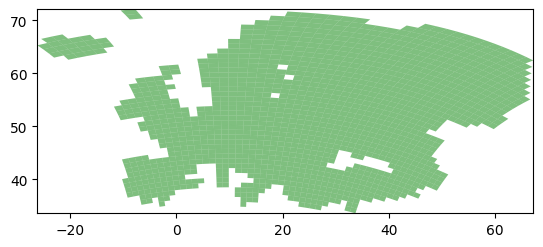

In [9]:
fig, ax = plt.subplots()

# Loop through features and plot them
for feature in grid_wildE:
    geom = feature.GetGeometryRef()
    
    if geom is not None:
        if geom.GetGeometryType() == ogr.wkbPolygon:
            # Plot polygons
            ring = geom.GetGeometryRef(0)  # Get the exterior ring
            coords = ring.GetPoints()
            x, y = zip(*coords)
            plt.fill(x, y, 'g', alpha=0.5)  # Fill the polygon with green if active_yn is 1

# Set plot limits and display the plot
ax.set_xlim(grid_wildE.GetExtent()[0], grid_wildE.GetExtent()[1])
ax.set_ylim(grid_wildE.GetExtent()[2], grid_wildE.GetExtent()[3])
plt.gca().set_aspect('equal', adjustable='box')  # Equal aspect ratio
plt.show()

grid_wildE.ResetReading()

### LUCAS points for fallow and active agriculture identification

In [10]:
# Define the dataset
LUCAS = ee.FeatureCollection('JRC/LUCAS_HARMO/THLOC/V1')
LUCAS

In [11]:
# Code for sampling LUCAS points in GEE
def filter_LUCAS_active_fallow(LUCAS, cover_class = [ "agriculture", "fallow"] ):
   
    # Convert class name string to LUCAS code for LC
    LU_classifications = {
    "agriculture": "U111",
    "fallow": "U112"
    }

    # create selector for LC type
    LU_classifications = pd.DataFrame(LU_classifications.items(), columns=['Land Use Type', 'Classification'])
    classification = LU_classifications[LU_classifications['Land Use Type'] == cover_class]['Classification'].values[0]

    # Create filter conditions for lc1 and lc2 separately (LC2 commented out, due to relative unimportance). Dominant LC will be LC1 if its cover is more than 50%
    lu1_filter = ee.Filter.stringContains('lu1', classification)
    #lc2_filter = ee.Filter.stringContains('lc2', classification)

    # Filter where lc1_perc or lc2_perc are equal to "> 75%" (and don't apply this to year 2006 where the perc cover is missing)
    year_filter = ee.Filter.eq('year', 2006)
    lu1_perc_filter = ee.Filter.Or(ee.Filter.equals('lu1_perc', "> 90 %"), year_filter)

    # Combine the two filter conditions with 'or' to filter the FeatureCollection
    filter_lc1 = ee.Filter.And(lu1_filter, lu1_perc_filter)

    # Add a filter to exclude features where parcel_area_ha is equal to desired plot sizes 
   # parcel_area_filter = ee.Filter.Or(ee.Filter.inList('parcel_area_ha', ["1 - 10 ha", "> 10 ha"]),  year_filter)
    
    # Observation quality filter. Select only in-situ points with close and accurate gps coords, or In office Photo interpritation
    filter_office_PI = ee.Filter.eq('obs_type', "In office PI")
    filter_gps_prec = ee.Filter.Or(ee.Filter.lt('gps_prec', 15), filter_office_PI)
    filter_obs_dist = ee.Filter.Or(ee.Filter.lt('obs_dist', 15), filter_office_PI)

    # Combine the filter conditions
   # combined_filter = ee.Filter.And(lu1_filter, parcel_area_filter, filter_gps_prec, filter_obs_dist)
    combined_filter = ee.Filter.And(lu1_filter, filter_gps_prec, filter_obs_dist)
    # Filter the feature collection
    filtered_LUCAS = LUCAS.filter(combined_filter)
    
    return filtered_LUCAS

In [36]:
grid_wildE.GetFeatureCount()

1420

In [12]:
def process_tile_LUCAS(tileFEAT, LUCAS, year, month_start=1, month_end=12, samples=5, LUCAS_years=[]):
    geom = tileFEAT.GetGeometryRef()
    
    # Build the EE-feature via the JSON conversion
    geom_json = json.loads(geom.ExportToJson())
    geom_coord = geom_json['coordinates']
    geom_coord = [c[0:2] for c in geom_coord[0]]
    geom_EE = ee.Geometry.Polygon(coords=geom_coord)
    
    year_lucas = None
    # Check if the provided year is in the set lucas_years
    if year not in LUCAS_years:
        # Find the closest year that is larger than the provided year
        year_lucas = LUCAS_find_closest_larger_year(year, LUCAS_years)
    else: 
        year_lucas = year
        
  #  print(year_lucas)

    # Get LUCAS data for the tile and filter it for the most appropriate year
    LUCAS_filtered = LUCAS.filterBounds(geom_EE).filter(ee.Filter.eq("year", year_lucas))
    
    # Limit the collection to the first 'samples' features
    LUCAS_filtered = LUCAS_filtered.limit(samples)
    #num_points = LUCAS_filtered.size()
    #count = ee.Number(num_points).getInfo()
    #print(count)

    # Update the year in the Seasonal_STMs_C2 function
    LND = Seasonal_STMs_C2(year, geom_EE, month_start, month_end, reducer="all")
    
        # add elevation and Bio Climactic data
    DEM           = ee.ImageCollection("COPERNICUS/DEM/GLO30").filterBounds(geom_EE).select(["DEM"]).mosaic()
    WorldClim_BIO = ee.Image("WORLDCLIM/V1/BIO").clip(geom_EE)
    
    LND = LND.addBands(DEM).addBands(WorldClim_BIO)
    
    vals = LND.sampleRegions(
        collection=LUCAS_filtered,
        properties=["id", "point_id", 'lc1', 'lu1_label'],
        scale=30,
        tileScale=4,
        geometries=True
    ).getInfo()

    if not vals['features']:
        return None
    else:
        # Initialize lists to store coordinates and data
        coordinates = []
        data_list = []

        for f in vals['features']:
            geometry = f['geometry']['coordinates']
            x_coord, y_coord = geometry[0], geometry[1]

            prop = f['properties']
            prop['x']    = x_coord
            prop['y']    = y_coord
            prop['year'] = year

            data_list.append(prop)

        # Create a DataFrame from the list of dictionaries
        tile_data = pd.DataFrame(data_list)

        return tile_data

In [27]:
# # Specify the directory where temporary pickle files are located
# pickle_dir = workPath + '/01_Sampling/lucas_points/LUCAS_sample_pickle/'

# # Call the function to delete all files in the directory
# DeleteAllItemsInFolder(pickle_dir)


Deleting all items in folder: D:/OneDrive - Humboldt-Universitaet zu Berlin, CMS/uni/WS_23_24/Geopy/MAP_git/01_Sampling/lucas_points/LUCAS_sample_pickle/
Folder D:/OneDrive - Humboldt-Universitaet zu Berlin, CMS/uni/WS_23_24/Geopy/MAP_git/01_Sampling/lucas_points/LUCAS_sample_pickle/ is already empty.


In [14]:
# Define input parameters

# list of landuse classes to loop over
land_use_classes = ["agriculture", "fallow"]

# years we want to process
years = {2006, 2009, 2012, 2015, 2018}

# years of LUCAS survey
LUCAS_years = [2006, 2009, 2012, 2015, 2018]
LUCAS = ee.FeatureCollection('JRC/LUCAS_HARMO/THLOC/V1')
samples = 500

pickle_dir = workPath + '/01_Sampling/lucas_points/LUCAS_sample_pickle/'

# Filter out the specific warning message
warnings.filterwarnings("ignore", message="Sleeping.*")

# Define month ranges
month_ranges = [
    (3, 5),   # March to May
    (5, 7),   # May to July
    (7, 9),    # July to September
    (3, 9),    # Whole Season
    (1,12),    # Whole Year
    (1, 3),   # Q1: January to March
    (4, 6),   # Q2: April to June
    (7, 9),   # Q3: July to September
    (10, 12) # Q4: October to December

    # Add more month ranges as needed
]

# Define a function to process tiles for a given year, cover class, and month range
def process_tiles_for_year_and_class_and_month_range(year, land_use_class, month_start, month_end):
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(lambda tile: process_tile_LUCAS(tile,
                                                                    LUCAS=LUCAS_filtered,
                                                                    samples=samples,
                                                                    year=year,
                                                                    month_start=month_start,
                                                                    month_end=month_end,
                                                                    LUCAS_years=LUCAS_years),
                                    grid_wildE))

    print(f"All tiles for {land_use_class} for {year} from month {month_start} to {month_end} have been processed")  # Print a progress message

    # Save the results to a temporary file using pickle
    with open(f'{pickle_dir}temporary_results_{land_use_class}_{year}_{month_start}-{month_end}.pkl', 'wb') as f:
        pickle.dump(results, f)

    return results

# Loop over each land use class
for land_use_class in land_use_classes:
    # Select land use class
    LUCAS_filtered = filter_LUCAS_active_fallow(LUCAS, land_use_class)

    # Loop over each month range
    for month_start, month_end in month_ranges:
        # Loop over each year
        for year in years:
            try:
                # Check for available pickle files for each year, land use class, and month range
                pickle_file = f'{pickle_dir}temporary_results_{land_use_class}_{year}_{month_start}-{month_end}.pkl'
                if os.path.exists(pickle_file):
                    print(f"Results for {land_use_class} for {year} from month {month_start} to {month_end} already processed. Skipping...")
                    continue

                # Process tiles for the current year, land use class, and month range
                process_tiles_for_year_and_class_and_month_range(year, land_use_class, month_start, month_end)

            except Exception as e:
                print(f"Error processing data for {land_use_class} for {year} from month {month_start} to {month_end}: {str(e)}")

print("Processing completed.")  # Print a message indicating that the processing is finished


Results for agriculture for 2018 from month 3 to 5 already processed. Skipping...
Results for agriculture for 2006 from month 3 to 5 already processed. Skipping...
Results for agriculture for 2009 from month 3 to 5 already processed. Skipping...
Results for agriculture for 2012 from month 3 to 5 already processed. Skipping...
Results for agriculture for 2015 from month 3 to 5 already processed. Skipping...
Results for agriculture for 2018 from month 5 to 7 already processed. Skipping...
Results for agriculture for 2006 from month 5 to 7 already processed. Skipping...
Results for agriculture for 2009 from month 5 to 7 already processed. Skipping...
Results for agriculture for 2012 from month 5 to 7 already processed. Skipping...
Results for agriculture for 2015 from month 5 to 7 already processed. Skipping...
Results for agriculture for 2018 from month 7 to 9 already processed. Skipping...
Results for agriculture for 2006 from month 7 to 9 already processed. Skipping...
Results for agri

### Saving pickled files as csv

In [ ]:
# Create an empty DataFrame to store the merged data for both land use classes
merged_data_both_classes = pd.DataFrame()

# Loop over each month range
for month_start, month_end in month_ranges:
    # Create an empty DataFrame to store the merged data for the current month range
    merged_data_month_range = pd.DataFrame()

    # Loop over each land use class
    for land_use_class in land_use_classes:
        # Loop over each year
        for year in years:
            # Combine the results into a DataFrame for the current year, land use class, and month range
            with open(f'{pickle_dir}temporary_results_{land_use_class}_{year}_{month_start}-{month_end}.pkl', 'rb') as f:
                results = pickle.load(f)
            df = pd.concat([pd.DataFrame(result) for result in results])
            df['land_use_classes'] = land_use_class  # Add the land use column
            merged_data_month_range = pd.concat([merged_data_month_range, df], ignore_index=True)

    # Add a column for the season (month range) to the merged data for the current month range
    merged_data_month_range['season'] = f"{month_start}-{month_end}"

    # Append the merged data for the current month range to the DataFrame for both land use classes
    merged_data_both_classes = pd.concat([merged_data_both_classes, merged_data_month_range], ignore_index=True)

    # Define the file path for the CSV file
    csv_file_path = workPath + f'/01_Sampling/lucas_points/LUCAS_sample_Both_Classes_{month_start}-{month_end}.csv'

    # Check if the CSV file already exists
    if os.path.exists(csv_file_path):
        print(f"CSV file for month range {month_start}-{month_end} already exists. Overwriting...")

    # Save the merged data for the current month range to a CSV file
    merged_data_month_range.rename(columns={'x': 'x_coord', 'y': 'y_coord'}, inplace=True)
    merged_data_month_range.to_csv(csv_file_path, index=False)

# Save the merged data for both land use classes to a single CSV file
merged_data_both_classes.rename(columns={'x': 'x_coord', 'y': 'y_coord'}, inplace=True)
merged_data_both_classes.to_csv(workPath + f'/01_Sampling/lucas_points/LUCAS_sample_Both_Classes_All.csv', index=False)

print("All CSV files generated.")  # Print a message indicating that the processing is finished

